In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def squaredLossGradient(yTrue, yPred):
    return yTrue - yPred

In [3]:
def absoluteLossGradient(yTrue, yPred):
    diff = yTrue - yPred
    return np.sign(diff) * (diff != 0)

In [4]:
def findBestStump(x, residuals, lossType='squared', k=20):
    bestLoss = float('inf')
    bestCut = None
    bestLeftValue = None
    bestRightValue = None

    thresholds = []
    step = 1.0 / (k + 1)
    val = step
    for a in range(k):
        thresholds.append(val)
        val += step

    for cut in thresholds:
        leftMask = x <= cut
        rightMask = x > cut

        if np.sum(leftMask) == 0 or np.sum(rightMask) == 0:
            continue  

        leftRes = residuals[leftMask]
        rightRes = residuals[rightMask]

        if lossType == 'squared':
            leftPred = np.mean(leftRes)
            rightPred = np.mean(rightRes)
            totalLoss = np.mean((leftRes - leftPred) ** 2) + np.mean((rightRes - rightPred) ** 2)
        elif lossType == 'absolute':
            leftPred = np.mean(leftRes)
            rightPred = np.mean(rightRes)
            totalLoss = np.mean(np.abs(leftRes - leftPred)) + np.mean(np.abs(rightRes - rightPred))

        if totalLoss < bestLoss:
            bestLoss = totalLoss
            bestCut = cut
            bestLeftValue = leftPred
            bestRightValue = rightPred

    return bestCut, bestLeftValue, bestRightValue

In [5]:
np.random.seed(2023217)
step = 1.0 / 100
eta = 0.01

x = []
val = 0
for _ in range(100):
    x.append(val)
    val += step
x = np.array(x)

noise = np.random.normal(0, 0.01, size=100)
y = np.sin(2 * np.pi * x) + np.cos(2 * np.pi * x) + noise

indices = np.arange(len(x))
np.random.shuffle(indices)

x_shuffled = x[indices]
y_shuffled = y[indices]

split_index = int(0.8 * len(x))
x_train = x_shuffled[:split_index]
y_train = y_shuffled[:split_index]
x_test = x_shuffled[split_index:]
y_test = y_shuffled[split_index:]

In [6]:
nRounds = 1000
eta = 0.01
tolerance = 1e-4
patience = 10

sort_indices_train = np.argsort(x_train)
x_train = x_train[sort_indices_train]
y_train = y_train[sort_indices_train]

sort_indices_test = np.argsort(x_test)
x_test = x_test[sort_indices_test]
y_test = y_test[sort_indices_test]

initialSq = np.mean(y_train)
predSq = np.full(y_train.shape, initialSq)
predSqTest = np.full(y_test.shape, initialSq)

initialAbs = np.mean(y_train)
predAbs = np.full(y_train.shape, initialAbs)
predAbsTest = np.full(y_test.shape, initialAbs)

lossSqTrain = []
lossAbsTrain = []

predictionsSqTrainHistory = {}
predictionsAbsTrainHistory = {}
predictionsSqTestHistory = {}
predictionsAbsTestHistory = {}

noImprovementSq = 0
noImprovementAbs = 0

earlyStopSqRound = None
earlyStopAbsRound = None

t = 1
while True:
    residualSq = y_train - predSq
    cut, leftVal, rightVal = findBestStump(x_train, residualSq, lossType='squared')
    stumpPredSq = np.where(x_train <= cut, leftVal, rightVal)
    predSq += eta * stumpPredSq

    mse = np.mean((y_train - predSq) ** 2)
    lossSqTrain.append(mse)

    if earlyStopSqRound is None:
        if t > 1 and abs(lossSqTrain[-2] - mse) < tolerance:
            noImprovementSq += 1
            if noImprovementSq >= patience:
                earlyStopSqRound = t
        else:
            noImprovementSq = 0

    testStumpPredSq = np.where(x_test <= cut, leftVal, rightVal)
    predSqTest += eta * testStumpPredSq

    residualAbs = np.sign(y_train - predAbs)
    cut, leftVal, rightVal = findBestStump(x_train, residualAbs, lossType='absolute')
    stumpPredAbs = np.where(x_train <= cut, leftVal, rightVal)
    predAbs += eta * stumpPredAbs

    mae = np.mean(np.abs(y_train - predAbs))
    lossAbsTrain.append(mae)

    if earlyStopAbsRound is None:
        if t > 1 and abs(lossAbsTrain[-2] - mae) < tolerance:
            noImprovementAbs += 1
            if noImprovementAbs >= patience:
                earlyStopAbsRound = t
        else:
            noImprovementAbs = 0

    testStumpPredAbs = np.where(x_test <= cut, leftVal, rightVal)
    predAbsTest += eta * testStumpPredAbs

    predictionsSqTrainHistory[t] = predSq.copy()
    predictionsAbsTrainHistory[t] = predAbs.copy()
    predictionsSqTestHistory[t] = predSqTest.copy()
    predictionsAbsTestHistory[t] = predAbsTest.copy()

    if (earlyStopSqRound is not None and earlyStopAbsRound is not None) or t >= nRounds:
        break

    t += 1

In [7]:
print(f"Convergence round for squared loss: {earlyStopSqRound}")
print(f"Convergence round for absolute loss: {earlyStopAbsRound}")

Convergence round for squared loss: 303
Convergence round for absolute loss: 594


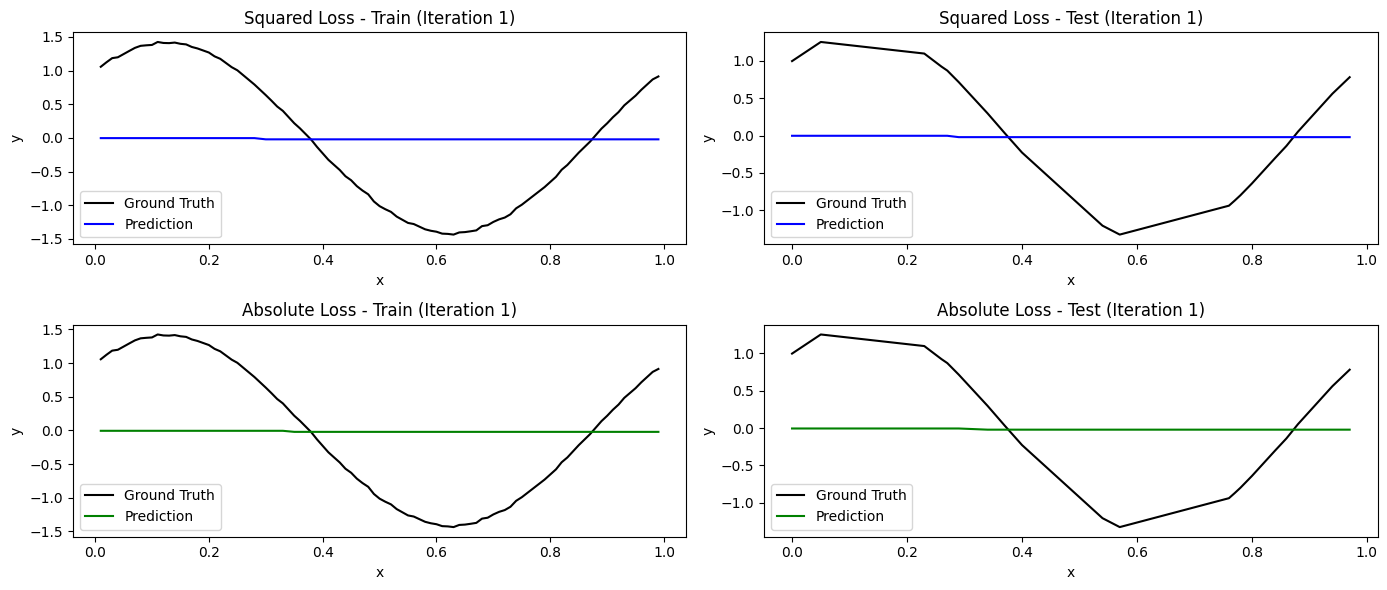

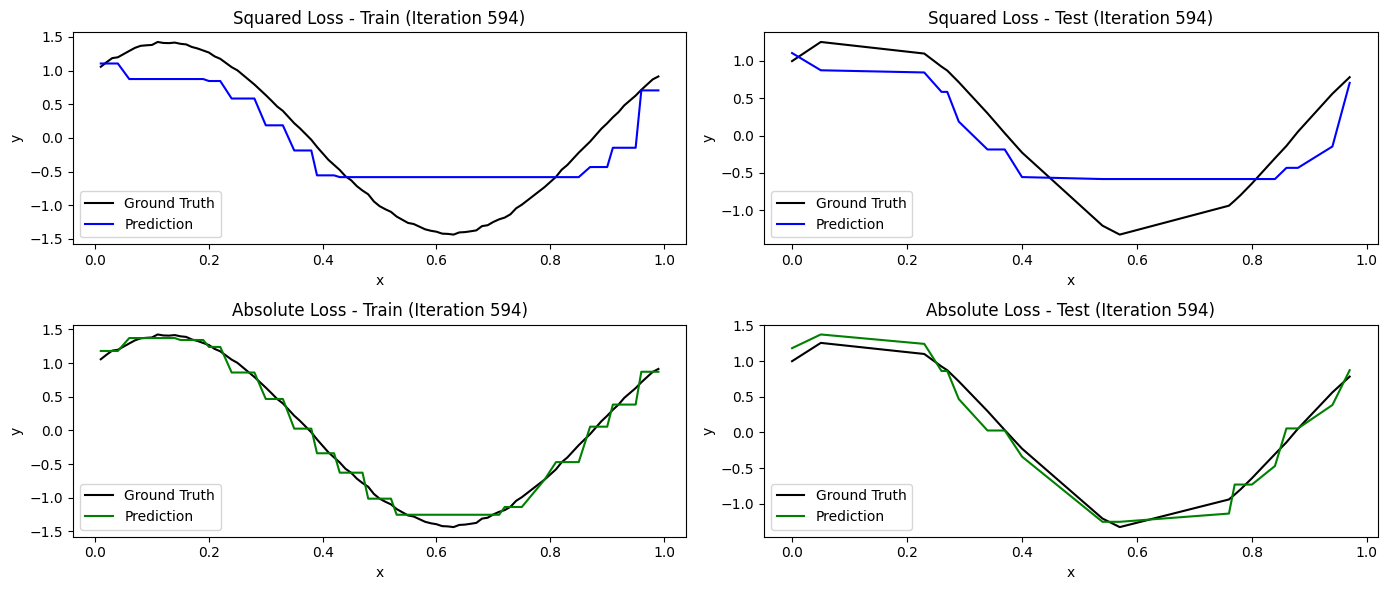

In [8]:
maxEarlyStop = max(
    r for r in [earlyStopSqRound, earlyStopAbsRound] if r is not None
)
selectedIterations = np.linspace(1, maxEarlyStop, 2, dtype=int).tolist()

for t in selectedIterations:
    plt.figure(figsize=(14, 6))
    
    plt.subplot(2, 2, 1)
    plt.title(f'Squared Loss - Train (Iteration {t})')
    plt.plot(x_train, y_train, label='Ground Truth', color='black')
    plt.plot(x_train, predictionsSqTrainHistory[t], label='Prediction', color='blue')
    #plt.plot(x_train, y_train, 'o-', label='Ground Truth', color='black')
    #plt.plot(x_train, predictionsSqTrainHistory[t], 'x-', label='Prediction', color='blue')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title(f'Squared Loss - Test (Iteration {t})')
    plt.plot(x_test, y_test, label='Ground Truth', color='black')
    plt.plot(x_test, predictionsSqTestHistory[t], label='Prediction', color='blue')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title(f'Absolute Loss - Train (Iteration {t})')
    plt.plot(x_train, y_train, label='Ground Truth', color='black')
    plt.plot(x_train, predictionsAbsTrainHistory[t], label='Prediction', color='green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.title(f'Absolute Loss - Test (Iteration {t})')
    plt.plot(x_test, y_test, label='Ground Truth', color='black')
    plt.plot(x_test, predictionsAbsTestHistory[t], label='Prediction', color='green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    plt.tight_layout()
    plt.show()

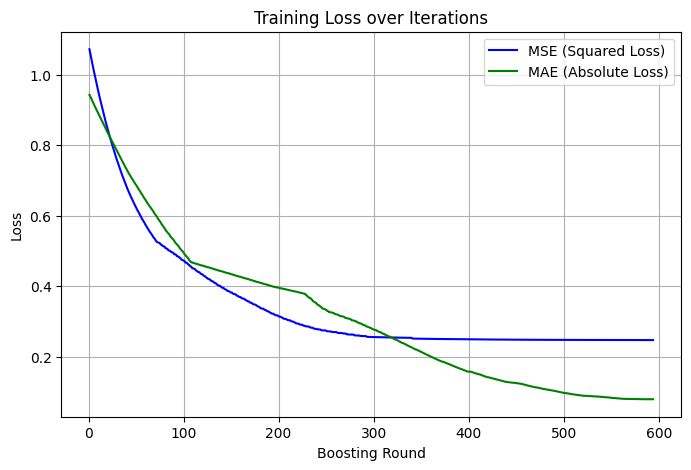

In [9]:
plt.figure(figsize=(8, 5))

actualRounds = len(lossSqTrain)

plt.plot(range(1, actualRounds + 1), lossSqTrain, label='MSE (Squared Loss)', color='blue')
plt.plot(range(1, actualRounds + 1), lossAbsTrain, label='MAE (Absolute Loss)', color='green')
plt.title('Training Loss over Iterations')
plt.xlabel('Boosting Round')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
